(c) 2024 Manuel Razo. This work is licensed under a [Creative Commons
Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/).
All code contained herein is licensed under an [MIT
license](https://opensource.org/licenses/MIT).

In [1]:
# Import project package
import ActiveInference as AI

# Import DataFrames
import DataFrames as DF

# Import basic math
import StatsBase
import Distributions
import Random

# Load plotting-related packages
using CairoMakie
import ColorSchemes
import Colors

# Activate backend
CairoMakie.activate!()

# Set Plotting style
AI.viz.theme_makie!()

# Variational Free Energy in Ising Models

This notebook accompanies a series of notes based on David MacKay's book
chapters on variational methods. In this notebook we will explore the concept of
variational free energy as applied to the Ising model.

## The Ising model

As a reminder, Ising models are a simple model of ferromagnetism. The model
consists of an array of spins that can be in one of two states, up or down (or
+1 or -1). The spins are magnetically coupled to their neighbors with two
possible types of couplings: 
- ferromagnetic (like spins want to align) or 
- antiferromagnetic (like spins want to anti-align).

Let the state $\underline{x}$ of an ising model with $N$ spins be a vector in
which each element $x_n$ is the state of the $n$-th spin. The energy of any
state $\underline{x}$, also called the Hamiltonian, is defined
as
$$
E(\underline{x}; \underline{\underline{J}}, \underline{h}) = - \frac{1}{2} 
\left[
    \sum_{m, n} J_{mn} x_m x_n + \sum_n h_n x_n,
\right],
\tag{1}
$$
where $J_{mn}$ is the energy coupling between spin $m$ and spin $n$ and $h_n$ is
an externally applied field. If $J_{mn} > 0$ the model is ferromagnetic, and if
$J_{mn} < 0$ the model is antiferromagnetic. The $1/2$ factor comes from the
double counting of the energy of each pair of spins, once as $(m, n)$ and once
as $(n, m)$. At equilibrium temperature $T$, the probability of a state
$\underline{x}$ is given by the Boltzmann distribution
$$
P(\underline{x} \mid \beta, \underline{\underline{J}}, \underline{h}) = 
\frac{1}{\mathcal{Z}} \exp\left(
    -\beta E(\underline{x}; \underline{\underline{J}}, \underline{h})
\right),
\tag{2}
$$
where $\beta = 1 / k_B T$ is the inverse temperature, and $\mathcal{Z}$ is the
partition function, defined as
$$
\mathcal{Z} = \sum_{\underline{x}} \exp\left(
    -\beta E(\underline{x}; \underline{\underline{J}}, \underline{h})
\right).
\tag{3}
$$

## Variational Free Energy

Computing the probability distribution of the Ising model, $P(\underline{x} \mid
\beta, \underline{\underline{J}}, \underline{h})$, is in general intractable
because of the partition function. Notice that $\mathcal{Z}$ is a sum over all
possible states of the system, which, even for a relatively small number of
spins can be a very large number. The number of configurations grows
exponentially with the number of spins, $2^N$. So, even for a small lattice of
$N = 100$ spins, the number of configurations is $2^{100} \approx 10^{30}$.
However, being able to compute the partition function for the system would be
extremely useful, as many thermodynamic properties of the system can be derived
from it.

To circumvent this problem, we propose approximating the true distribution
$P(\underline{x} \mid \beta, \underline{\underline{J}}, \underline{h})$ with a
simpler parametric distribution $Q(\underline{x};\underline{\theta})$ that is
easier to compute. This $Q$ distribution is defined by a set of parameters
$\underline{\theta}$ that we are free to tune. The goal is to find the set of
parameters $\underline{\theta}$ that best approximates the true distribution
$P(\underline{x} \mid \beta, \underline{\underline{J}}, \underline{h})$.
Mathematically, this goal is expressed as finding the set of parameters that
minimalizes the Kullback-Leibler divergence between the approximate and true
distributions
$$
\underline{\theta}^* = \min_{\underline{\theta}}\; D_{KL}\left(
    Q(\underline{x};\underline{\theta}) \mid\mid
    P(\underline{x} \mid \beta, \underline{\underline{J}}, \underline{h}) 
\right).
\tag{4}
$$
One can show that this operation leads to the following expression:
$$
\sum_{\underline{x}} Q(\underline{x};\underline{\theta})
\ln \frac{
    Q(\underline{x};\underline{\theta})
}{
    \exp\left[
        -\beta E(\underline{x}; \underline{\underline{J}}, \underline{h})
    \right]
} \geq - \ln \mathcal{Z}.
\tag{5}
$$
where we used the so-called Gibbs inequality, which states that the
Kullback-Leibler divergence is a strictly positive quantity. The right-hand side
of the inequality is the negative logarithm of the partition function. This is,
up to a factor of $k_BT$, the free energy of the system,
$$
\mathcal{F} = - k_BT \ln \mathcal{Z}.
\tag{6}
$$


This means that the left-hand side of the inequality in Eq. 5 is an upper bound
on the free energy of the system. We, therefore, call this quantity the
*Variational Free Energy*
$$
\beta \mathcal{\tilde{F}}(\underline{\theta}) \equiv 
\sum_{\underline{x}} Q(\underline{x};\underline{\theta})
\ln \frac{
    Q(\underline{x};\underline{\theta})
}{
    \exp\left[
        -\beta E(\underline{x}; \underline{\underline{J}}, \underline{h})
    \right]
}.
\tag{7}
$$
The variational free energy can be rewritten in very interesting ways. For
example, it is easy to show that we can rewrite the variational free energy as
$$
\beta \mathcal{\tilde{F}}(\underline{\theta}) = 
\beta \left\langle 
E(\underline{x}; \underline{\underline{J}}, \underline{h})
\right\rangle_{Q(\underline{x};\underline{\theta})} -
S_{Q(\underline{x};\underline{\theta})},
\tag{8}
$$
where $\left\langle \cdot \right\rangle_{Q(\underline{x};\underline{\theta})}$
is the expectation taken over the variational distribution $Q$ and $S_{Q}$ is
the entropy of the variational distribution. Written in this way, is clear that
the variational free energy is a proper free energy, as it reflects the
competition between energy and entropy.

Furthermore, since the variational free energy is an upper bound on
$-\ln\mathcal{Z}$, we can use the variational free energy toset a lower bound on
$\mathcal{Z}$, 
$$
\mathcal{\tilde{Z}} \equiv \exp\left(
    -\beta \mathcal{\tilde{F}}(\underline{\theta})
\right) \leq \mathcal{Z}.
\tag{9}
$$
Thus, if we can compute this variational free energy, we can approximate the
partition function of the system and therefore obtain many thermodynamic
properties of the system.

### Can the variational free energy be computed?

A natural question to ask is how is this variational free energy helpful if it
also involves a sum over all possible states of the system. The simple answer is
that depending on the variational distribution $Q$ we choose, this sum can be
much easier to compute than the partition function. Let's look at an example.

### Ising model with a mean-field approximation

For the Ising model introduced earlier, we can approximate the distribution
$P(\underline{x} \mid \beta, \underline{\underline{J}}, \underline{h})$ with a
**separable** distribution of the form
$$
Q(\underline{x};\underline{\theta}) = \frac{1}{\mathcal{Z}_Q}
\exp\left(
    \sum_n \theta_n x_n
\right).
\tag{10}
$$
Notice there is no coupling between spins in this distribution, so every spin is
independent of the others. This means that the partition function can be written
as the product of the partition functions of each spin
$$
\mathcal{Z}_Q = \prod_n \mathcal{Z}_{q_n},
\tag{11}
$$
where
$$
\mathcal{Z}_{q_n} = \exp(\theta_n) + \exp(-\theta_n).
\tag{12}
$$

For every spin, we have that the probability of being in the state $x_n = +1$ is
$$
q_n = \frac{\exp(\theta_n)}{\exp(\theta_n) + \exp(-\theta_n)} =
\frac{1}{1 + \exp(-2\theta_n)}.
\tag{13}
$$

To compute the variational free energy, we need to compute the expectation of
the energy and the entropy of the distribution $Q$. The expected energy is
computed as
$$
\left\langle E \right\rangle_{Q} = \sum_{\underline{x}} 
Q(\underline{x}; \underline{\theta}) 
E(\underline{x}; \underline{\underline{J}}, \underline{h}) = 
\sum_{\underline{x}} 
Q(\underline{x}; \underline{\theta}) 
\left[
    -\frac{1}{2} \sum_{m, n} J_{mn} x_m x_n - \sum_n h_n x_n
\right].
\tag{14}
$$
However, recall that $Q$ has no coupling between spins. Therefore, this is the
sum of the product of **independent** random variables, for which we have
$$
\left\langle x_m x_n \right\rangle_{Q} = \left\langle x_m \right\rangle_{Q}
\left\langle x_n \right\rangle_{Q}
\tag{15}
$$
Therefore, we define the expected value for each spin as
$$
\bar{x}_n = \left\langle x_n \right\rangle_{Q} =
q_n (+1) + (1 - q_n)(-1) = 2q_n - 1.
\tag{16}
$$
We can then write the expected energy as
$$
\left\langle E \right\rangle_{Q} = 
-\frac{1}{2} \sum_{m, n} J_{mn} \bar{x}_m \bar{x}_n - \sum_n h_n \bar{x}_n.
\tag{17}
$$

For the entropy, we have that since each spin is independent and the entropy is
an extensive quantity, we can write the entropy of the distribution as the sum
of the entropies of each spin
$$
S_Q = -\sum_n \left[
    q_n \ln q_n + (1 - q_n) \ln (1 - q_n)
\right].
\tag{18}
$$

#### Two-spin Ising model

Let's look at the variational free energy for a simple two-spin Ising model. For
this very simple case, we define the energy function as
$$
E(x_1, x_2) = -x_1 x_2
\tag{19}
$$
The variational free energy is then given by
$$
\beta \mathcal{\tilde{F}}(\theta_1, \theta_2) =
\underbrace{-\beta \bar{x}_1 \bar{x}_2}_{\left\langle E\right\rangle_Q} - 
\underbrace{S_{q_1} - S_{q_2}}_{S_Q}.
\tag{20}
$$

We will plot this variational free energy as a function of the variational
parameters $\theta_1$ and $\theta_2$. But first, let's compute the necessary
quantities.

In [18]:
# Define value of β
β = 1.0

# Define range of θ parameters
θ_range = range(-3, 3, length=100)

# Compute probability of xₙ = +1 for each θ
qₘ = qₙ = 1 ./ (1 .+ exp.(-2 * θ_range))

# Compute expected spin state x̄ₙ for each θ
x̄ₘ = x̄ₙ = 2 * qₙ .- 1

# Compute spin state entropy for each θ
Sₘ = Sₙ = -qₙ .* log.(qₙ) .- (1 .- qₙ) .* log.(1 .- qₙ)

# Initialize empty array to store free energy
F = Matrix{Float64}(undef, length(θ_range), length(θ_range))

# Loop over all θₘ and θₙ
for m in eachindex(θ_range)
    for n in eachindex(θ_range)
        # Compute free energy
        F[m, n] = -β * (x̄ₘ[m] * x̄ₙ[n]) - Sₘ[m] - Sₙ[n]
    end # for n
end # for m

Now, let's plot the variational free energy

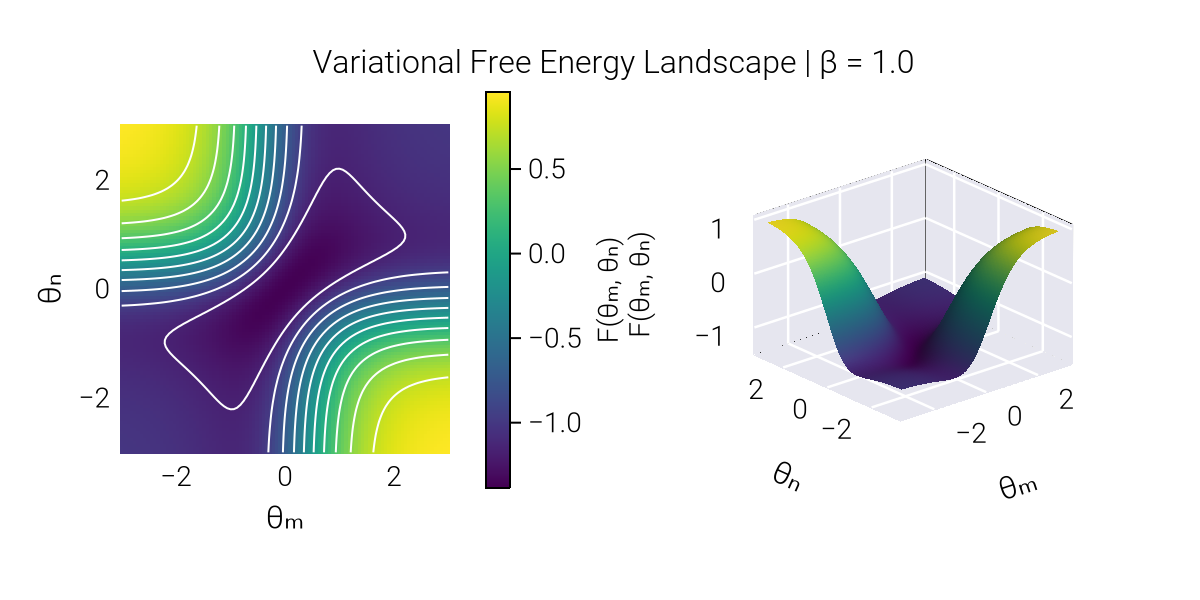

In [19]:
# Initialize figure
fig = Figure(size=(600, 300))

# Add overall grid layout
gl = fig[1, 1] = GridLayout()

# Add grid layout for first plot
gl1 = gl[1, 1] = GridLayout()

# Add axis for VFE heatmap
ax1 = Axis(gl1[1, 1], xlabel="θₘ", ylabel="θₙ", aspect=AxisAspect(1))

# Add heatmap for VFE
hm = heatmap!(ax1, θ_range, θ_range, F, colormap=:viridis)

# Add contour lines for VFE
contour!(ax1, θ_range, θ_range, F, levels=10, linewidth=1, color=:white)

# Add colorbar for VFE
Colorbar(gl1[1, 2], hm, label="F(θₘ, θₙ)")

# Add grid layout for second plot
gl2 = gl[1, 2] = GridLayout()

# Add 3D axis for VFE
ax2 = Axis3(gl2[1, 1], xlabel="θₘ", ylabel="θₙ", zlabel="F(θₘ, θₙ)")

# Add surface plot for VFE
surface!(ax2, θ_range, θ_range, F, colormap=:viridis)

# Add overall title
Label(
    gl[1, :, Top()],
    "Variational Free Energy Landscape | β = $β",
    fontsize=16,
)

fig

Let's repeat this calculation for a higher temperature (lower $\beta$).

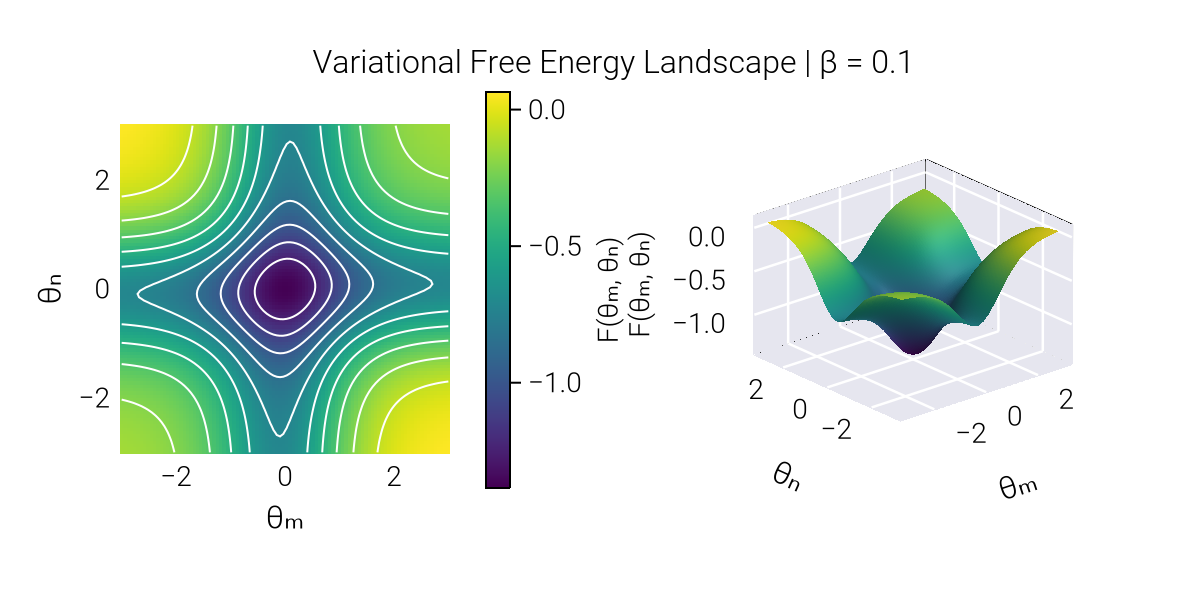

In [17]:
# Define value of β
β = 0.1

# Define range of θ parameters
θ_range = range(-3, 3, length=100)

# Compute probability of xₙ = +1 for each θ
qₘ = qₙ = 1 ./ (1 .+ exp.(-2 * θ_range))

# Compute expected spin state x̄ₙ for each θ
x̄ₘ = x̄ₙ = 2 * qₙ .- 1

# Compute spin state entropy for each θ
Sₘ = Sₙ = -qₙ .* log.(qₙ) .- (1 .- qₙ) .* log.(1 .- qₙ)

# Initialize empty array to store free energy
F = Matrix{Float64}(undef, length(θ_range), length(θ_range))

# Loop over all θₘ and θₙ
for m in eachindex(θ_range)
    for n in eachindex(θ_range)
        # Compute free energy
        F[m, n] = -β * (x̄ₘ[m] * x̄ₙ[n]) - Sₘ[m] - Sₙ[n]
    end # for n
end # for m

# Initialize figure
fig = Figure(size=(600, 300))

# Add overall grid layout
gl = fig[1, 1] = GridLayout()

# Add grid layout for first plot
gl1 = gl[1, 1] = GridLayout()

# Add axis for VFE heatmap
ax1 = Axis(gl1[1, 1], xlabel="θₘ", ylabel="θₙ", aspect=AxisAspect(1))

# Add heatmap for VFE
hm = heatmap!(ax1, θ_range, θ_range, F, colormap=:viridis)

# Add contour lines for VFE
contour!(ax1, θ_range, θ_range, F, levels=10, linewidth=1, color=:white)

# Add colorbar for VFE
Colorbar(gl1[1, 2], hm, label="F(θₘ, θₙ)")

# Add grid layout for second plot
gl2 = gl[1, 2] = GridLayout()

# Add 3D axis for VFE
ax2 = Axis3(gl2[1, 1], xlabel="θₘ", ylabel="θₙ", zlabel="F(θₘ, θₙ)")

# Add surface plot for VFE
surface!(ax2, θ_range, θ_range, F, colormap=:viridis)

# Add overall title
Label(
    gl[1, :, Top()],
    "Variational Free Energy Landscape | β = $β",
    fontsize=16,
)

fig

Now for a lower temperature (higher $\beta$).

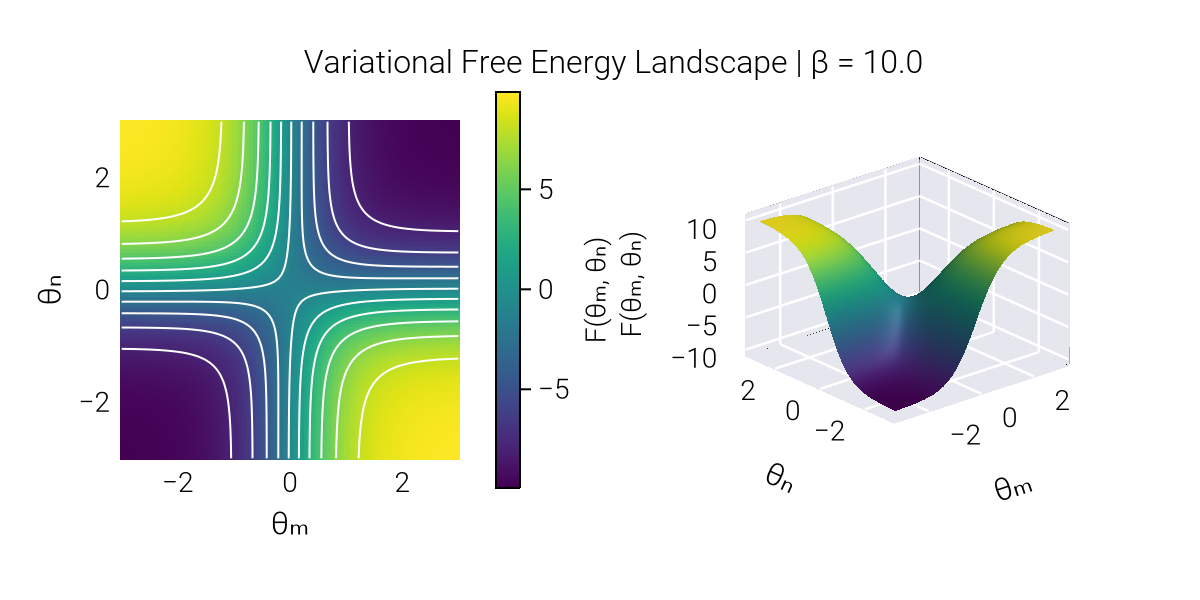

In [20]:
# Define value of β
β = 10.0

# Define range of θ parameters
θ_range = range(-3, 3, length=100)

# Compute probability of xₙ = +1 for each θ
qₘ = qₙ = 1 ./ (1 .+ exp.(-2 * θ_range))

# Compute expected spin state x̄ₙ for each θ
x̄ₘ = x̄ₙ = 2 * qₙ .- 1

# Compute spin state entropy for each θ
Sₘ = Sₙ = -qₙ .* log.(qₙ) .- (1 .- qₙ) .* log.(1 .- qₙ)

# Initialize empty array to store free energy
F = Matrix{Float64}(undef, length(θ_range), length(θ_range))

# Loop over all θₘ and θₙ
for m in eachindex(θ_range)
    for n in eachindex(θ_range)
        # Compute free energy
        F[m, n] = -β * (x̄ₘ[m] * x̄ₙ[n]) - Sₘ[m] - Sₙ[n]
    end # for n
end # for m

# Initialize figure
fig = Figure(size=(600, 300))

# Add overall grid layout
gl = fig[1, 1] = GridLayout()

# Add grid layout for first plot
gl1 = gl[1, 1] = GridLayout()

# Add axis for VFE heatmap
ax1 = Axis(gl1[1, 1], xlabel="θₘ", ylabel="θₙ", aspect=AxisAspect(1))

# Add heatmap for VFE
hm = heatmap!(ax1, θ_range, θ_range, F, colormap=:viridis)

# Add contour lines for VFE
contour!(ax1, θ_range, θ_range, F, levels=10, linewidth=1, color=:white)

# Add colorbar for VFE
Colorbar(gl1[1, 2], hm, label="F(θₘ, θₙ)")

# Add grid layout for second plot
gl2 = gl[1, 2] = GridLayout()

# Add 3D axis for VFE
ax2 = Axis3(gl2[1, 1], xlabel="θₘ", ylabel="θₙ", zlabel="F(θₘ, θₙ)")

# Add surface plot for VFE
surface!(ax2, θ_range, θ_range, F, colormap=:viridis)

# Add overall title
Label(
    gl[1, :, Top()],
    "Variational Free Energy Landscape | β = $β",
    fontsize=16,
)

fig